# CSCI 453 "Please Compile" Final Project

### Logan Zug, Ben Alrbright, Gavin Fry

In [7]:
# Start with all of the includes we'll need for the project...

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [9]:
# Begin...

In [10]:
df = pd.read_csv("reviews.csv")

In [11]:
df.drop(['unix_timestamp_created', 'unix_timestamp_updated'], axis=1, inplace=True)
df.dropna(inplace=True)

In [12]:
df.rename(columns={'weighted_vote_score': 'helpful_score', 'voted_up': 'is_recommended', 'votes_up': 'upvotes'}, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1452657 entries, 0 to 1455441
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   steamid             1452657 non-null  int64  
 1   appid               1452657 non-null  int64  
 2   is_recommended      1452657 non-null  bool   
 3   upvotes             1452657 non-null  int64  
 4   votes_funny         1452657 non-null  int64  
 5   helpful_score       1452657 non-null  float64
 6   playtime_forever    1452657 non-null  int64  
 7   playtime_at_review  1452657 non-null  int64  
 8   num_games_owned     1452657 non-null  int64  
 9   num_reviews         1452657 non-null  int64  
 10  review              1452657 non-null  object 
dtypes: bool(1), float64(1), int64(8), object(1)
memory usage: 123.3+ MB


# Gavin

## Feature-Scaling (Playtime After Negative Review)

In [14]:
# Make a mask for all rows within df that have recommended = false
mask = df[(df['is_recommended']==False)]

# Take a sample of 100 reviews with a random seed 100
data = mask.sample(n=100, random_state = 100, replace = False)

# Establish a new column, 'playtime_after_review' that takes the difference of playtime forever and at review.
data['playtime_after_review'] = data['playtime_forever'] - data['playtime_at_review']

# Determine the lower and upper range for 'playtime_after_review'
q_low = data["playtime_after_review"].quantile(0.05)
q_high  = data["playtime_after_review"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
data = data[(data["playtime_after_review"] < q_high) & (data["playtime_after_review"] > q_low)]

# Determine the lower and upper range for 'playtime_at_review'
q_low = data["playtime_at_review"].quantile(0.05)
q_high  = data["playtime_at_review"].quantile(0.95)

# Take the previously determined lower and upper and use them to filter the data
data = data[(data["playtime_at_review"] < q_high) & (data["playtime_at_review"] > q_low)]

# Sort the dataframe by 'playtime after review'
data = data.sort_values(by="playtime_after_review", ascending = True)

In [15]:
# Describing the sample we took...
data.playtime_after_review.describe()

count      37.000000
mean      337.945946
std       405.951895
min         1.000000
25%        43.000000
50%       170.000000
75%       431.000000
max      1321.000000
Name: playtime_after_review, dtype: float64

In [16]:
# Initialize scaler
scaler = MinMaxScaler()

# To scale playtime_after_review
scaler.fit(data['playtime_after_review'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
data['playtime_after_review']=scaler.transform(data['playtime_after_review'].values.reshape(-1,1))

# To scale playtime_after_review
scaler.fit(data['playtime_at_review'].values.reshape(-1,1)) 

# Fit the new scaled data into the dataframe
data['playtime_at_review_scaled']=scaler.transform(data['playtime_at_review'].values.reshape(-1,1))

# Instantiate the Label Encoder Object
label_encoder = LabelEncoder()

# Fit and transform the column into new column 'individual' to keep track of users sequentally instead of as an id
data['Individual'] = label_encoder.fit_transform(data['steamid'])

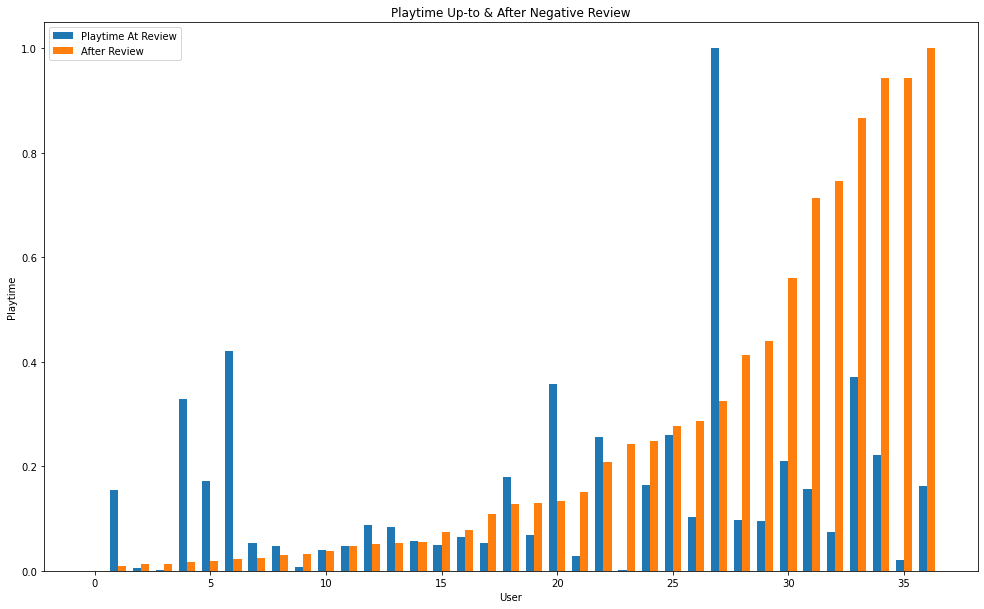

In [17]:
# Set the labels to be each individual within the sample
labels = data.Individual

# the label locations
x = np.arange(len(labels))
# the width of the bars
width = 0.35  

# Prepare the figure for sublots, since it will be a paired bar graph
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data.playtime_at_review_scaled, width, label='Playtime At Review')
rects2 = ax.bar(x + width/2, data.playtime_after_review, width, label='After Review')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Playtime')
ax.set_xlabel('User')
ax.set_title('Playtime Up-to & After Negative Review')
ax.legend()

# Set the layout and size for the figure.
fig.tight_layout()
fig.set_size_inches(15,10)

# Show the plot
plt.show()

In [ ]:
# In the above graph, you can see that on average, users who reviewed negatively played less time after the review than before.
# This is to be expected, since if an individual does not like a game, they probably won't come back to play it in the future.
# There is a minor subset of individuals that played the game for a short amount of time, reviewed it negatively, then continued
# to play it for a significant amount of time.  This could be explained by a few things.  First, I believe individuals could
# have left the review as a joke, saying "wasn't that great" then having thousands of hours somewhat ironically.  Next, I 
# believe this could be explained by individuals reviewing a game negatively, then returning to play the game once it has had
# significant fixes without updating there previous review.

## Clustering (Helpfulness vs Funniness)

In [18]:
# Take the two columns we want from OG df...
df2 = df[["votes_funny", "helpful_score"]]

# Drop 0's
df2= df2[df2['votes_funny'] != 0]
df2= df2[df2['helpful_score'] != 0]

# Take a sample of 5000 reviews with a random seed 1...
data = df2.sample(n=5000, random_state = 1, replace = False)

# Determine the lower and upper range for votes_funny
q_lowFunny = data["votes_funny"].quantile(0.10)
q_hiFunny  = data["votes_funny"].quantile(0.90)

# Determine the lower and upper range for helpful....
q_lowHelpful = data["helpful_score"].quantile(0.10)
q_hiHelpful  = data["helpful_score"].quantile(0.90)

# Take the previously determined lower and upper and use them to filter the data
df_filtered = data[(data["votes_funny"] < q_hiFunny) & (data["votes_funny"] > q_lowFunny)]
df_filtered = data[(data["helpful_score"] < q_hiHelpful) & (data["helpful_score"] > q_lowHelpful)]

# Define number of clusters
num_clusters = 10
 
# Creating instance of PCA and transforming the data from df_filtered to fit PCA
pca = PCA()
data_pca = pca.fit_transform(df_filtered)

# Creating the PC columns within pca_df for use in clustering
pca_df = pd.DataFrame(data_pca,columns=['PC1','PC2'])

# Create and fit the KMeans model
km = KMeans(n_clusters=num_clusters)
km.fit(df_filtered)
 
# Predict the target variable
pred=km.predict(df_filtered)

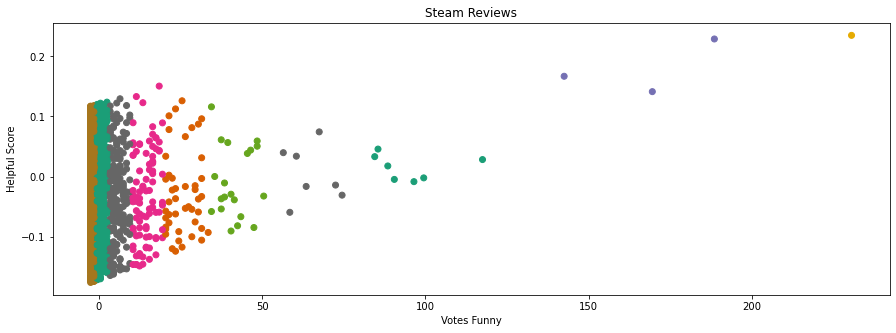

In [19]:
# Plot the Clusters
plt.figure(figsize=(15,5))
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred, cmap = 'Dark2')
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Display the plot
plt.show()

In [ ]:
# For this section, I created a scatter plot to represent the relation of "Votes Funny" vs "Helpful Score".  In this scenario I
# also clustered based on the votes funny.  The ultimate result of this excercise was that there really wasn't much correlation
# between votes funny and helpful score.  What I did notice is that it seems like a few reviews were buried by some individuals
# that accrued quite a large sum of both helpful and funny votes.  The clustering can be used to identify that quite a large 
# portion of the data is within the lower end of the funny votes, and all data tended to revolve around 

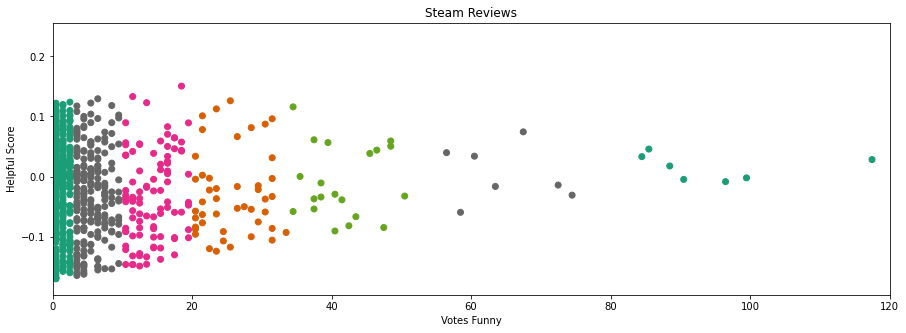

In [20]:
# Plot the Clusters
plt.figure(figsize=(15,5))
plt.scatter(pca_df.PC1, pca_df.PC2, c=pred, cmap = 'Dark2')
# Set title of the plot 
plt.title('Steam Reviews')
# Set x-axis label
plt.xlabel('Votes Funny')
# Set y-axis label
plt.ylabel('Helpful Score')
# Set the xlim for the second plot
plt.xlim([0, 120])
# Display the plot
plt.show()

# Logan


[Text(0.5, 0, 'Characters in Review'),
 Text(0, 0.5, 'Average Number of Games Owned')]

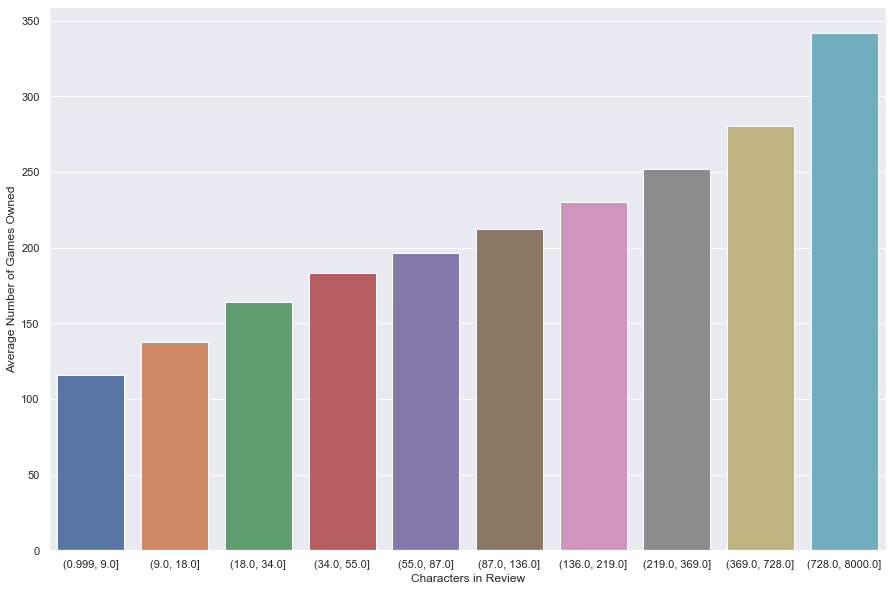

In [31]:
#Bar graphs using review character counts

#getting rid of large funny vote outliers 
df = df[df['votes_funny'] < 4294967292]

#cut into equal sized bins based on character lenght of review then get mean by grouping on bin

data = df.groupby(pd.qcut(df.review.map(lambda x: len(x)), q=10)).mean().reset_index()

#review lenght to number of games owned
sns.set(rc={'figure.figsize':(15,10)})
fig = sns.barplot(x='review', y='num_games_owned', data=data)
fig.set(xlabel='Characters in Review', ylabel="Average Number of Games Owned")

[Text(0.5, 0, 'Characters in Review'), Text(0, 0.5, 'Average Helpful Score')]

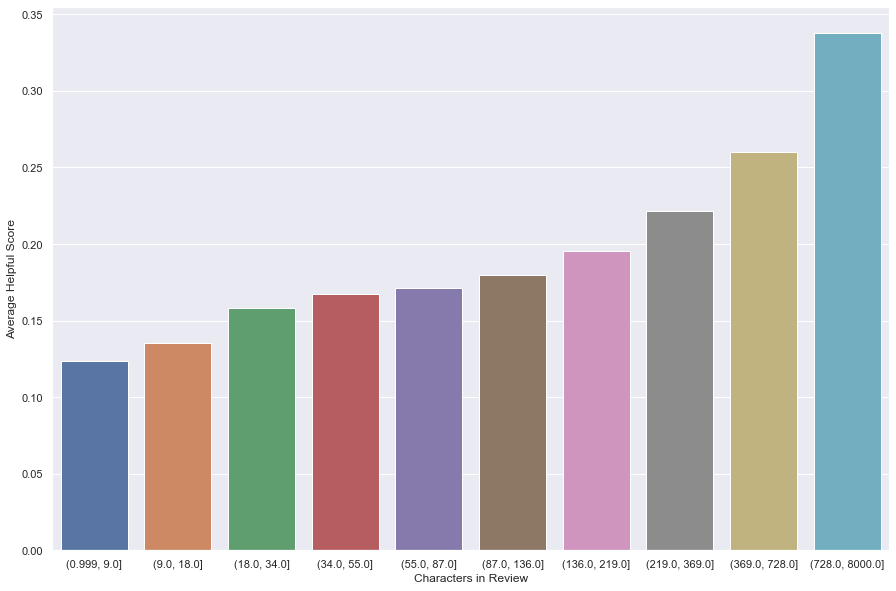

In [32]:
#review length to helpful score
sns.set(rc={'figure.figsize':(15,10)})
fig = sns.barplot(x='review', y='helpful_score', data=data)
fig.set(xlabel='Characters in Review', ylabel="Average Helpful Score")

[Text(0.5, 0, 'Characters in Review'), Text(0, 0.5, 'Average Funny Votes')]

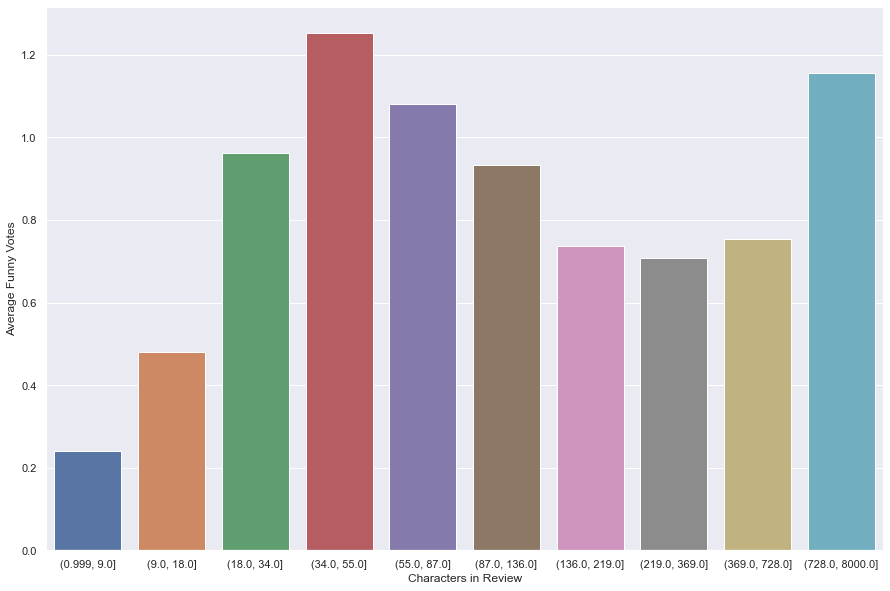

In [33]:
#review lengh to funny votes
sns.set(rc={'figure.figsize':(15,10)})
fig = sns.barplot(x='review', y='votes_funny', data=data)
fig.set(xlabel='Characters in Review', ylabel="Average Funny Votes")

(0.0, 50000.0)

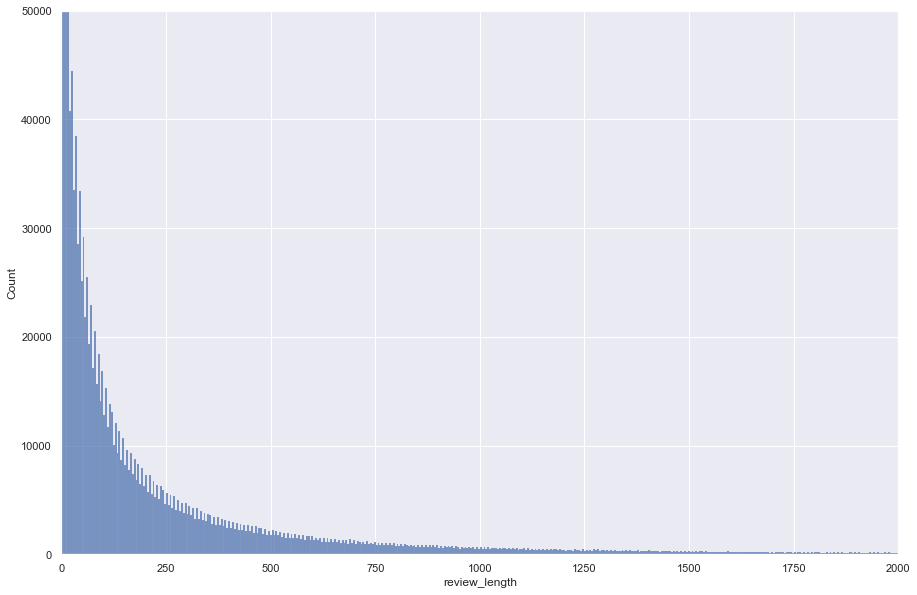

In [24]:
#histagram of review character lengths
df["review_length"] = df.review.map(lambda x: len(x))
sns.histplot(x='review_length', data=df)
plt.xlim(0,2000)
plt.ylim(0,50000)

In [25]:
#word count
import re

def get_counts(reviews):
    word_count = {}
    for review in reviews:
        words = review.split()
        for word in words:
            word = re.sub('[^a-zA-Z]+', '', word)
            word = word.lower()
            if word in word_count:
                word_count[word] = word_count[word] + 1
            else: 
                word_count[word] =  1
    word_count.pop('', None)
    return word_count
#this takes a while to run
word_count_all = get_counts(df['review']) #all reviews words count
word_count_r = get_counts( df[df['is_recommended'] == True]["review"]) #words for recommended
word_count_nr = get_counts(df[df['is_recommended'] == False]["review"]) #words for not recommended
print("done")

done


<BarContainer object of 20 artists>

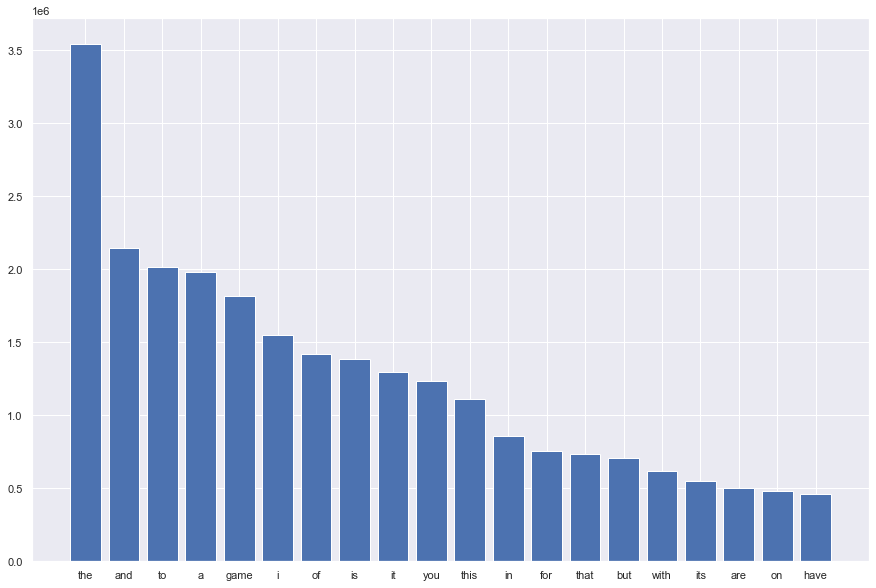

In [26]:
top_words = sorted(word_count_all.items(), key=lambda item: item[1], reverse=True)[:20]
word = list(zip(*top_words))[0]
count = list(zip(*top_words))[1]
plt.bar(word, count)

In [27]:
#compare words between occurance between recommended and not
print("bugs")
print(word_count_nr["bugs"]/sum(word_count_nr.values()))
print(word_count_r["bugs"]/sum(word_count_r.values()))

print("graphics")
print(word_count_nr["graphics"]/sum(word_count_nr.values()))
print(word_count_r["graphics"]/sum(word_count_r.values()))

print("fun")
print(word_count_nr["fun"]/sum(word_count_nr.values()))
print(word_count_r["fun"]/sum(word_count_r.values()))

bugs
0.0008208228866571659
0.0006496456160415867
graphics
0.0007479215878761849
0.0010397673215364243
fun
0.002033706392389707
0.005532069513873233


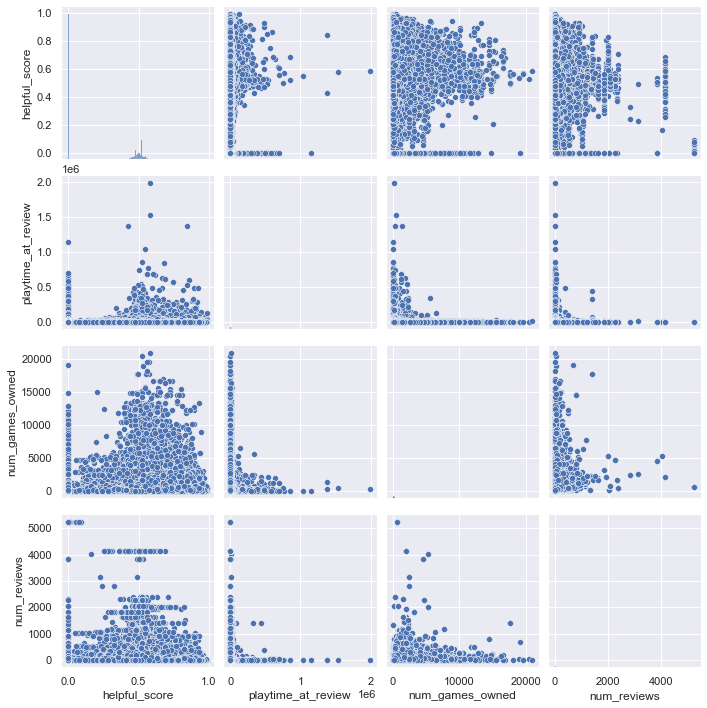

In [28]:
#pair plot
pair_data = df[['helpful_score', 'playtime_at_review', 'num_games_owned', 'num_reviews']]
sns.pairplot(pair_data)

([<matplotlib.patches.Wedge at 0x2638dffddc0>,
 [Text(0.9096987835473929, 0.6184239025234987, 'Risk of Rain 2'),
  Text(-0.0616403932646773, 1.0982715793091327, 'Bloons TD 6'),
  Text(-0.8164370330097482, 0.7371774353100069, 'Raft'),
  Text(-1.0966758461882347, 0.08545225794161179, 'Beat Saber'),
  Text(-0.9436563060316322, -0.5652546117341589, 'Slay the Spire'),
  Text(-0.4821343654811806, -0.9887094889916145, "Assassin's Creed Odyssey"),
  Text(0.08764906484265185, -1.0965024584706633, 'Stick Fight: The Game'),
  Text(0.6129529856680931, -0.9133940208697288, 'Sekiro™: Shadows Die Twice'),
  Text(0.9427035539437044, -0.5668421379730949, 'Resident Evil 2'),
  Text(1.0832116424550715, -0.19144852480441404, 'Ravenfield')],
 [Text(0.49619933648039605, 0.33732212864918104, '19%'),
  Text(-0.03362203268982398, 0.5990572250777086, '14%'),
  Text(-0.4453292907325899, 0.40209678289636736, '11%'),
  Text(-0.5981868251935825, 0.046610322513606424, '10%'),
  Text(-0.5147216214717993, -0.308320697

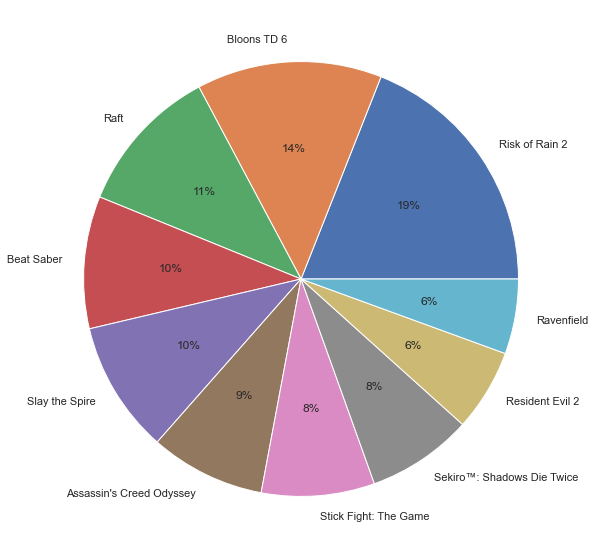

In [29]:
#Pie chart for share of top 10 most reviewed games
top_ten_games = df.groupby("appid").count().reset_index().sort_values(ascending=False, by='is_recommended')['appid'][:10].to_list()
top_ten_values = df.groupby("appid").count().reset_index().sort_values(ascending=False, by='is_recommended')['steamid'][:10].to_list()
labels = ['Risk of Rain 2', 'Bloons TD 6', 'Raft', 'Beat Saber', 'Slay the Spire', 'Assassin\'s Creed Odyssey', 'Stick Fight: The Game'
          , 'Sekiro™: Shadows Die Twice', 'Resident Evil 2', 'Ravenfield']
plt.pie(top_ten_values, labels = labels, autopct='%.0f%%')

(0.0, 15000.0)

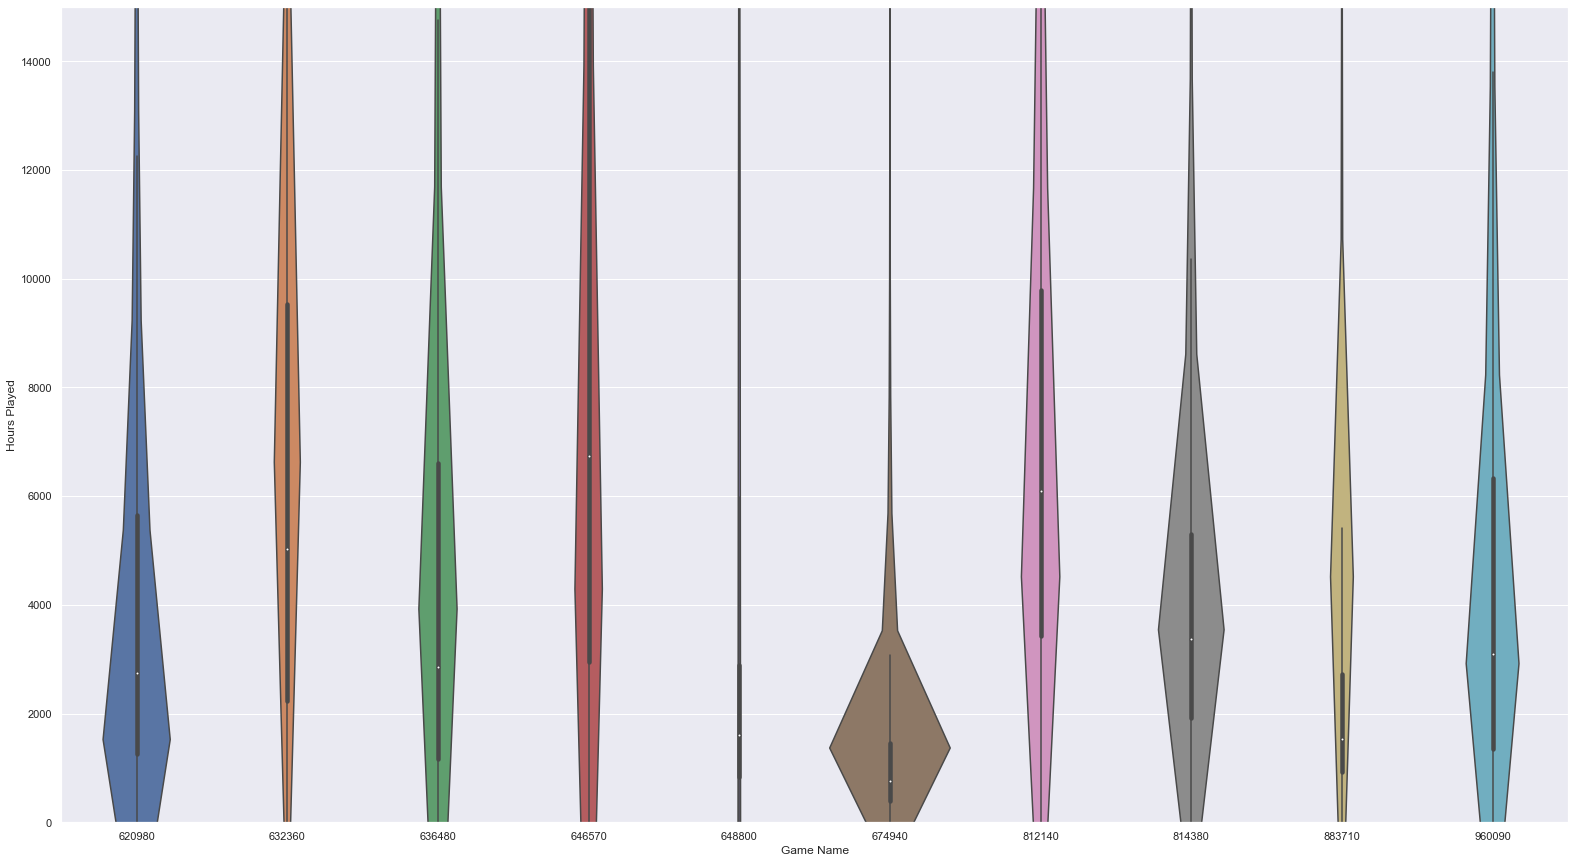

In [30]:
#Violin plot for hours played of 10 most popular games
data = df.copy()
data = data[data['appid'].isin(top_ten_games)]
games = {
    632360: "Risk of Rain 2", 
    960090: "Bloons TD 6", 
    648800: "Raft", 
    620980: "Beat Saber",
    646570: "Slay the Spire",
    812140: "Assassin's Creed Odyssey",
    674940: "Stick Fight: The Game",
    814380: "Sekiro™: Shadows Die Twice",
    883710: "Resident Evil 2",
    636480: "Ravenfield"
}
data["game_name"] = data.appid.map(lambda x: games[x])

plt.figure(figsize=(27,15))
fig = sns.violinplot(x='appid', y='playtime_forever', data=data)
fig.set(xlabel='Game Name', ylabel='Hours Played')
plt.ylim(0,15000)